# **Aging Biomarkers - Methylation based Chronological Age Estimator**


## Step 1: Import Libraries

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from biolearn.data_library import DataLibrary
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

## Step 2: Load and Preview GSE40279 Dataset(Train) and GSE157131 Dataset(Evaluation)

In [ ]:
# Load & Preview Evaluation Data
evaluation_data = DataLibrary().get("GSE157131").load()

Note: This dataset will take a few minutes to load and may fail if you have insufficient memory


In [9]:
# Preview its methylation matrix (first 5 CpGs × 5 samples)
print("🔍 Evaluation β-matrix:")
display(evaluation_data.dnam.head().iloc[:, :5])

🔍 Evaluation β-matrix:


,GSM4753639,GSM4753640,GSM4753641,GSM4753642,GSM4753644
ID_REF,,,,,
cg00000029,0.743143,0.706606,0.628885,0.562915,0.614170
cg00000109,0.956468,0.953614,0.962331,0.952262,0.952814
cg00000165,0.151411,0.127816,0.092166,0.077027,0.120263
cg00000236,0.904720,0.874442,0.863355,0.894204,0.876077
cg00000289,0.864994,0.845839,0.883417,0.891442,0.873706


In [ ]:
# Load GSE40279 from BioLearn
data = DataLibrary().get("GSE40279").load()

,age,sex,ethnicity,tissue
id,,,,
GSM989827,67.0,1,Caucasian - European,whole blood
GSM989828,89.0,1,Caucasian - European,whole blood
GSM989829,66.0,1,Caucasian - European,whole blood
GSM989830,64.0,1,Caucasian - European,whole blood
GSM989831,62.0,1,Caucasian - European,whole blood
...,...,...,...,...
GSM990623,78.0,1,Caucasian - European,whole blood
GSM990624,71.0,2,Caucasian - European,whole blood
GSM990625,68.0,2,Caucasian - European,whole blood


In [7]:
# Preview sample‐level metadata
print("🔍 data.metadata:")
display(data.metadata.head())

# Preview CpG beta values (first 5 sites × 5 samples)
print("🔍 data.dnam:")
display(data.dnam.head().iloc[:, :5])


🔍 data.metadata:


,age,sex,ethnicity,tissue
id,,,,
GSM989827,67.0,1,Caucasian - European,whole blood
GSM989828,89.0,1,Caucasian - European,whole blood
GSM989829,66.0,1,Caucasian - European,whole blood
GSM989830,64.0,1,Caucasian - European,whole blood
GSM989831,62.0,1,Caucasian - European,whole blood


🔍 data.dnam:


,GSM989827,GSM989828,GSM989829,GSM989830,GSM989831
id,,,,,
cg00000029,0.464197,0.454883,0.485764,0.480785,0.501220
cg00000108,0.941091,0.939033,0.918802,0.929908,0.934548
cg00000109,0.911182,0.596455,0.870333,0.889689,0.890450
cg00000165,0.132014,0.206917,0.162861,0.197780,0.148437
cg00000236,0.717861,0.723935,0.719196,0.704061,0.754913


## Step 3: Feature Selection via Bootstrapped Linear Regression

In [10]:
X = data.dnam.T.values
y = data.metadata["age"].values

n_bootstrap = 20
threshold    = 0.05
counts       = np.zeros(X.shape[1])

for _ in range(n_bootstrap):
    idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
    lr  = LinearRegression().fit(X[idx], y[idx])
    sig = np.where(np.abs(lr.coef_) > threshold)[0]
    counts[sig] += 1

stable_lr_idx   = np.where(counts > n_bootstrap * 0.6)[0]
stable_lr_names = data.dnam.index[stable_lr_idx].tolist()

print(f"✅ LinearRegression‐stable CpGs ({len(stable_lr_names)}):")
print(stable_lr_names)


✅ LinearRegression‐stable CpGs (1480):
['cg00000029', 'cg00000108', 'cg00000109', 'cg00000165', 'cg00000236', 'cg00000289', 'cg00000292', 'cg00000321', 'cg00000363', 'cg00000622', 'cg00000658', 'cg00000714', 'cg00000721', 'cg00000734', 'cg00000769', 'cg00000807', 'cg00000884', 'cg00000905', 'cg00000924', 'cg00000948', 'cg00000957', 'cg00001099', 'cg00001245', 'cg00001249', 'cg00001261', 'cg00001349', 'cg00001364', 'cg00001446', 'cg00001510', 'cg00001582', 'cg00001583', 'cg00001593', 'cg00001594', 'cg00001687', 'cg00001747', 'cg00001791', 'cg00001793', 'cg00001809', 'cg00001854', 'cg00001874', 'cg00001930', 'cg00002028', 'cg00002033', 'cg00002080', 'cg00002116', 'cg00002145', 'cg00002190', 'cg00002224', 'cg00002236', 'cg00002406', 'cg00002426', 'cg00002464', 'cg00002473', 'cg00002490', 'cg00002531', 'cg00002591', 'cg00002593', 'cg00002597', 'cg00002646', 'cg00002660', 'cg00002749', 'cg00002769', 'cg00002808', 'cg00002809', 'cg00002810', 'cg00002837', 'cg00002930', 'cg00003014', 'cg00003

## Step 3.1: Lasso Feature Selection

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV

# Prepare data
y = data.metadata["age"].values
X_lr = data.dnam.loc[stable_lr_names].T.values  # shape: (samples, CpGs)

# Run LassoCV
lasso = LassoCV(cv=5, random_state=42, max_iter=10000, n_alphas=100).fit(X_lr, y)

# Extract non-zero coefficients 
coef = pd.Series(lasso.coef_, index=stable_lr_names)
stable_lasso = coef[coef.abs() > 0].index.tolist()

# Print selected CpGs
print(f"✅ Lasso selected {len(stable_lasso)} CpG sites:")
for cg in stable_lasso:
    print("   ", cg)

# Display in table
display(pd.DataFrame({
    "Selected_CpG": stable_lasso
}))  # ✅ <-- closing parenthesis was missing here

# Save to CSV
selected_features_df = pd.DataFrame({
    "Selected_CpG": stable_lasso
})

output_path = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/selected_cpgs_lasso.csv"
selected_features_df.to_csv(output_path, index=False)

print(f"📁 Saved selected CpGs to: {output_path}")

✅ Lasso selected 403 CpG sites:
    cg00004073
    cg00009523
    cg00017157
    cg00033213
    cg00051154
    cg00106621
    cg00159523
    cg00167913
    cg00243527
    cg00292135
    cg00573770
    cg00593462
    cg00593900
    cg00616572
    cg00695177
    cg00881894
    cg00944631
    cg01003961
    cg01074797
    cg01077178
    cg01097406
    cg01111179
    cg01153376
    cg01156747
    cg01188578
    cg01191806
    cg01196788
    cg01203766
    cg01207684
    cg01228941
    cg01491428
    cg01528542
    cg01542019
    cg01543583
    cg01571001
    cg01778345
    cg01820962
    cg01821635
    cg01829241
    cg01836455
    cg01849085
    cg01872593
    cg01957222
    cg02024925
    cg02070028
    cg02113055
    cg02159489
    cg02299007
    cg02379549
    cg02453013
    cg02479782
    cg02621287
    cg02627240
    cg02650266
    cg02760293
    cg02771117
    cg02814135
    cg02872426
    cg03075889
    cg03088219
    cg03172657
    cg03329597
    cg03372334
    cg03393996
    cg03

,Selected_CpG
0,cg00004073
1,cg00009523
2,cg00017157
3,cg00033213
4,cg00051154
...,...
398,cg27286106
399,cg27288829
400,cg27313566
401,cg27468880


📁 Saved selected CpGs to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/selected_cpgs_lasso.csv


## Step 4: Build Feature DF & Train/Test Split

In [12]:
# Build DataFrame with selected features
df = data.dnam.loc[stable_lasso].T.copy()
df["age"] = data.metadata["age"]

# Define features and target
X_feat = df[stable_lasso].values
y_feat = df["age"].values

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42
)

# Print split details
print(f"✅ Train shape: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test  shape: X={X_test.shape}, y={y_test.shape}")

✅ Train shape: X=(524, 403), y=(524,)
✅ Test  shape: X=(132, 403), y=(132,)


## Step 5: Modeling

## **MODEL 1: ElasticNet Regression**

ElasticNet Test MSE: 15.3138


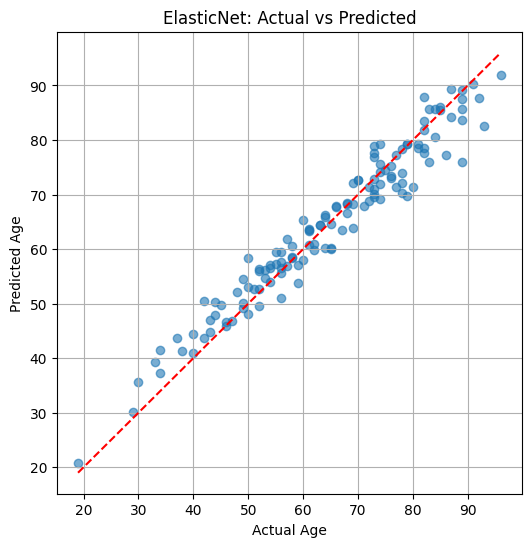

✅ Model and predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


In [ ]:
# Train model
enet = ElasticNet(alpha=0.01, l1_ratio=0.3, max_iter=10000, random_state=42)
enet.fit(X_train, y_train)

# Predict and evaluate
y_pred_enet = enet.predict(X_test)
mse_enet = mean_squared_error(y_test, y_pred_enet)
print(f"ElasticNet Test MSE: {mse_enet:.4f}")

# Plot predictions
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_enet, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("ElasticNet: Actual vs Predicted")
plt.grid(True)
plt.show()

# Save model and predictions
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"
joblib.dump(enet, os.path.join(output_dir, "ElasticNet_model.joblib"))

predictions_df = pd.DataFrame({
    "Actual_Age": y_test,
    "Predicted_Age": y_pred_enet
})
predictions_df.to_csv(os.path.join(output_dir, "ElasticNet_test_predictions.csv"), index=False)

print(f"✅ Model and predictions saved to: {output_dir}")

## **MODEL 2: Random Forest Regressor**

RandomForest Test MSE: 45.2403


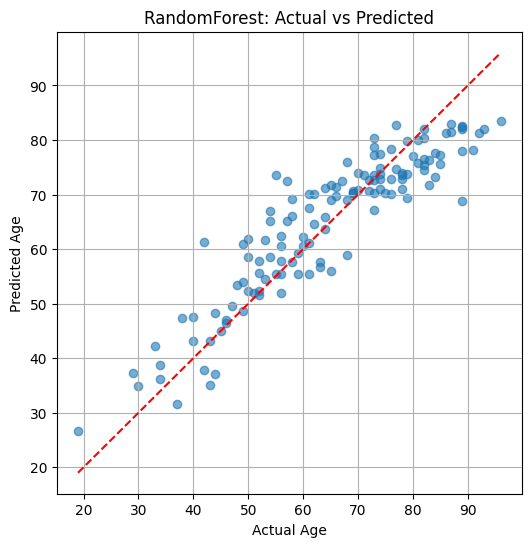

✅ Model and predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


In [16]:
# Set your local output directory
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"

# Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"RandomForest Test MSE: {mse_rf:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("RandomForest: Actual vs Predicted")
plt.grid(True)
plt.show()

# Save model and predictions
joblib.dump(rf, os.path.join(output_dir, "RandomForest_model.joblib"))

pd.DataFrame({
    "Actual_Age": y_test,
    "Predicted_Age": y_pred_rf
}).to_csv(os.path.join(output_dir, "RandomForest_test_predictions.csv"), index=False)

print("✅ Model and predictions saved to:", output_dir)

## **MODEL 2.1: Random Forest Regressor**

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Python(66742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66748) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66749) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(66751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RandomForest (Tuned) Test MSE: 44.6391


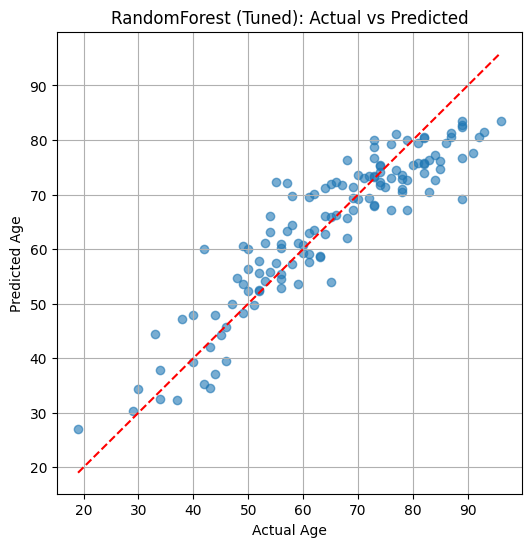

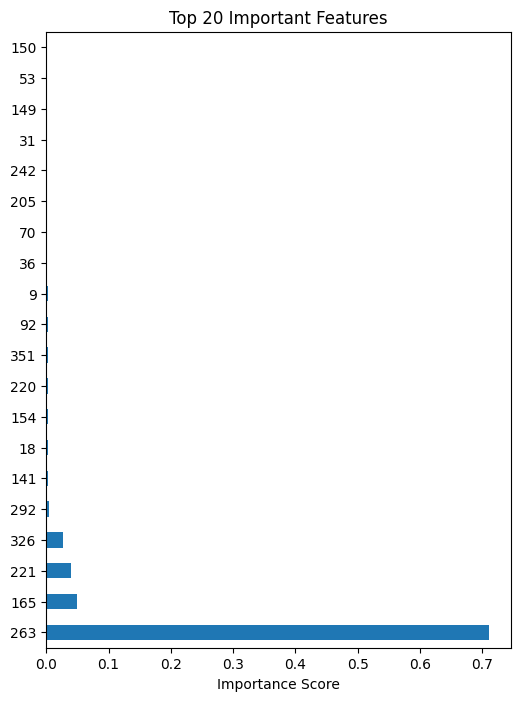

✅ Tuned model and predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


In [19]:
# Set your output directory
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"

# Apply age transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train_log)
best_rf = grid_search.best_estimator_

# Predict & evaluate
y_pred_rf_log = best_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf_log)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"RandomForest (Tuned) Test MSE: {mse_rf:.4f}")

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("RandomForest (Tuned): Actual vs Predicted")
plt.grid(True)
plt.show()

# Feature Importance Plot
importances = pd.Series(best_rf.feature_importances_, index=range(X_train.shape[1]))
top_features = importances.sort_values(ascending=False).head(20)
top_features.plot(kind="barh", figsize=(6, 8))
plt.title("Top 20 Important Features")
plt.xlabel("Importance Score")
plt.show()

# Save model and predictions
joblib.dump(best_rf, os.path.join(output_dir, "RandomForest_model_tuned.joblib"))

pred_df = pd.DataFrame({
    "Actual_Age": y_test,
    "Predicted_Age": y_pred_rf
})
pred_df.to_csv(os.path.join(output_dir, "RandomForest_test_predictions_tuned.csv"), index=False)

print("✅ Tuned model and predictions saved to:", output_dir)

## **MODEL 2.2: Random Forest Regressor**

✅ Train shape: X=(524, 403), y=(524,)
✅ Test  shape: X=(132, 403), y=(132,)
📉 RandomForest Test MSE: 45.3366


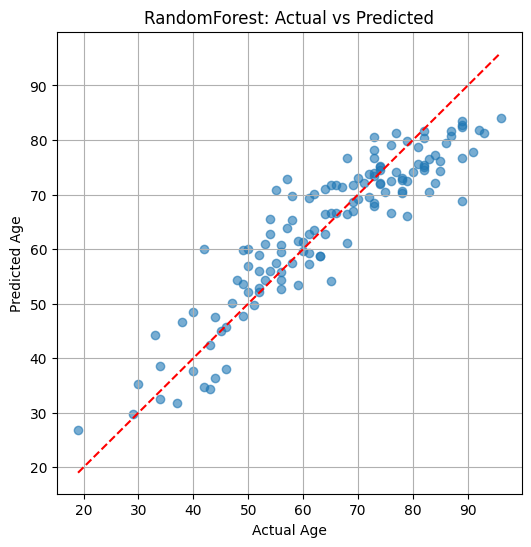

✅ Model and predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


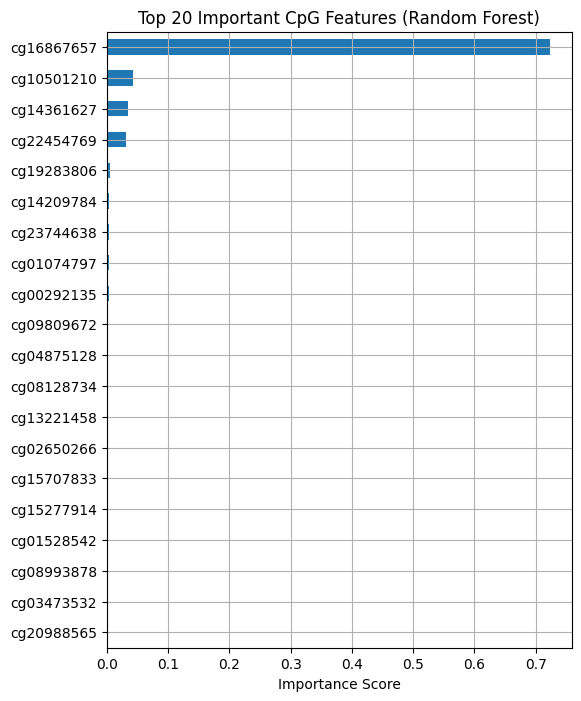

In [21]:
# === Step 1: Prepare feature matrix using stable_lasso CpGs ===
df = data.dnam.loc[stable_lasso].T.copy()
df["age"] = data.metadata["age"]

X_feat = df[stable_lasso].values
y_feat = df["age"].values

# === Step 2: Log-transform age to stabilize variance ===
y_feat_log = np.log1p(y_feat)

# === Step 3: Train-test split ===
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_feat, y_feat_log, test_size=0.2, random_state=42
)

# Inverse transform for evaluation
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

print(f"✅ Train shape: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test  shape: X={X_test.shape}, y={y_test.shape}")

# === Step 4: Train Random Forest Regressor ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

# === Step 5: Predict and evaluate ===
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)

mse_rf = mean_squared_error(y_test, y_pred)
print(f"📉 RandomForest Test MSE: {mse_rf:.4f}")

# === Step 6: Plot Actual vs Predicted ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("RandomForest: Actual vs Predicted")
plt.grid(True)
plt.show()

# === Step 7: Save model and predictions ===
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"

joblib.dump(rf, os.path.join(output_dir, "RandomForest_model.joblib"))

pd.DataFrame({
    "Actual_Age": y_test,
    "Predicted_Age": y_pred
}).to_csv(os.path.join(output_dir, "RandomForest_test_predictions.csv"), index=False)

print("✅ Model and predictions saved to:", output_dir)

# === Step 8: Feature Importance Plot ===
importances = pd.Series(rf.feature_importances_, index=stable_lasso)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(6, 8))
top_features.plot(kind="barh")
plt.title("Top 20 Important CpG Features (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

## **MODEL 3: Gradient Boosting Regressor**

GradientBoosting Test MSE: 37.4601


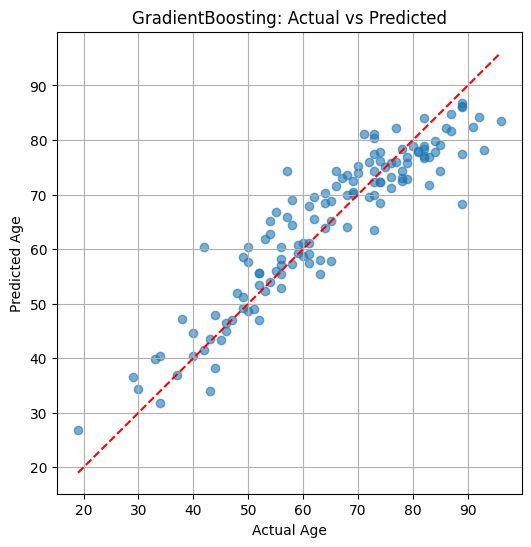

✅ Model and predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


In [20]:
# Set your local output directory
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"

# Train
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

# Predict & evaluate
y_pred_gb = gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"GradientBoosting Test MSE: {mse_gb:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("GradientBoosting: Actual vs Predicted")
plt.grid(True)
plt.show()

# Save model and predictions
joblib.dump(gb, os.path.join(output_dir, "GradientBoosting_model.joblib"))

pd.DataFrame({
    "Actual_Age": y_test,
    "Predicted_Age": y_pred_gb
}).to_csv(os.path.join(output_dir, "GradientBoosting_test_predictions.csv"), index=False)

print("✅ Model and predictions saved to:", output_dir)

## **MODEL 4: Support Vector Regression (SVR)**

SVR Test MSE: 43.0152


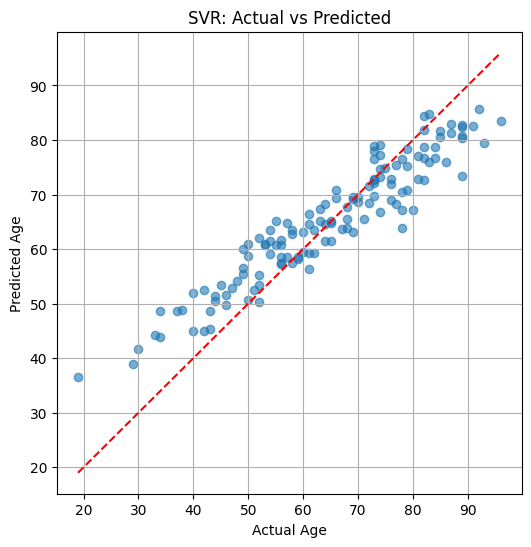

✅ SVR model and predictions saved.


In [31]:
# Set your local output directory
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"

# Train SVR model (you can tune kernel, C, and epsilon later)
svr = SVR(kernel='rbf', C=10, epsilon=0.1)
svr.fit(X_train, y_train)

# Predict & evaluate
y_pred_svr = svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR Test MSE: {mse_svr:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("SVR: Actual vs Predicted")
plt.grid(True)
plt.show()

# Save model and predictions
joblib.dump(svr, os.path.join(output_dir, "SVR_model.joblib"))
pd.DataFrame({
    "Actual_Age": y_test,
    "Predicted_Age": y_pred_svr
}).to_csv(os.path.join(output_dir, "SVR_test_predictions.csv"), index=False)

print("✅ SVR model and predictions saved.")

## **MODEL 5: RidgeCV**

Ridge Regression Test MSE: 11.9197


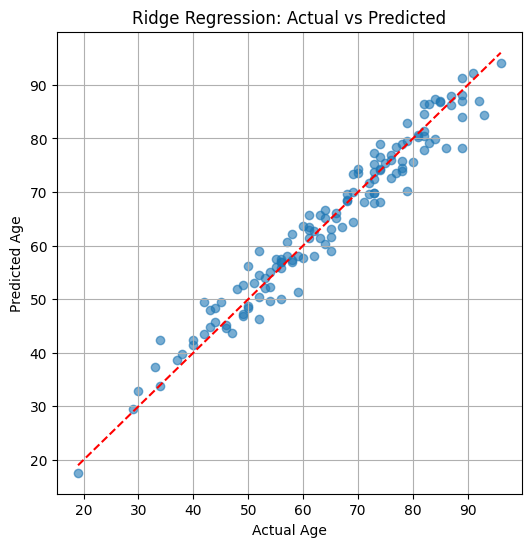

✅ Ridge model and predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib
import os
import pandas as pd

# Set your local output directory
output_dir = "/Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1"

# Train Ridge Regression with built-in cross-validation over a range of alphas
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

# Predict & evaluate
y_pred_ridge = ridge.predict(X_test)
mse_ridge    = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression Test MSE: {mse_ridge:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Ridge Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

# Save model and predictions
joblib.dump(ridge, os.path.join(output_dir, "Ridge_model.joblib"))

pd.DataFrame({
    "Actual_Age":    y_test,
    "Predicted_Age": y_pred_ridge
}).to_csv(os.path.join(output_dir, "Ridge_test_predictions.csv"), index=False)

print("✅ Ridge model and predictions saved to:", output_dir)


## Step 6: Save Best Model

In [60]:
import joblib
import os

# Gather test‐set MSEs
mse_dict = {
    "ElasticNet":    mse_enet,
    "RandomForest":  mse_rf,
    "GradientBoosting": mse_gb,
    "SVR":           mse_svr,
    "Ridge":         mse_ridge
}

# Sort ascending by MSE and pick best + second best
sorted_models    = sorted(mse_dict.items(), key=lambda x: x[1])
best_name, _     = sorted_models[0]
second_name, _   = sorted_models[1]

# Model name → fitted object mapping
model_map = {
    "ElasticNet":    enet,
    "RandomForest":  rf,
    "GradientBoosting": gb,
    "SVR":           svr,
    "Ridge":         ridge
}

best_mod   = model_map[best_name]
second_mod = model_map[second_name]

# Report
print(f"🏆 Best Model:   {best_name} (MSE={mse_dict[best_name]:.4f})")
print(f"🥈 Second Best: {second_name} (MSE={mse_dict[second_name]:.4f})")

# Save both to disk
joblib.dump(best_mod,   os.path.join(output_dir, f"{best_name}_model.joblib"))
joblib.dump(second_mod, os.path.join(output_dir, f"{second_name}_model.joblib"))
print("✅ Top two models saved to:", output_dir)


🏆 Best Model:   Ridge (MSE=11.9197)
🥈 Second Best: ElasticNet (MSE=15.3138)
✅ Top two models saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


## Step 7: Predict & Evaluate on Test Data

✅ Ridge Test MSE: 11.9197


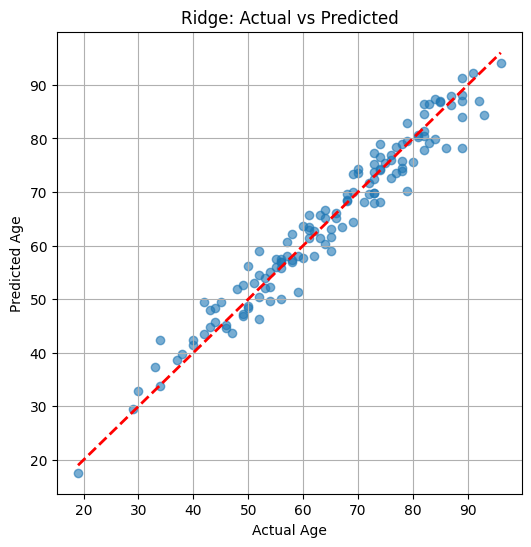

✅ Test predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1


In [61]:
import joblib
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Load the best model
best_model_path = os.path.join(output_dir, f"{best_name}_model.joblib")
best_model = joblib.load(best_model_path)

# Predict on the test split
y_test_pred = best_model.predict(X_test)

# Compute and print MSE
mse_best = mean_squared_error(y_test, y_test_pred)
print(f"✅ {best_name} Test MSE: {mse_best:.4f}")

# Plot Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2)
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title(f"{best_name}: Actual vs Predicted")
plt.grid(True)
plt.show()

# Save test‐set predictions to CSV
pred_df = pd.DataFrame({
    "Actual_Age":    y_test,
    "Predicted_Age": y_test_pred
})
pred_df.to_csv(os.path.join(output_dir, f"{best_name}_test_predictions.csv"), index=False)
print(f"✅ Test predictions saved to: {output_dir}")

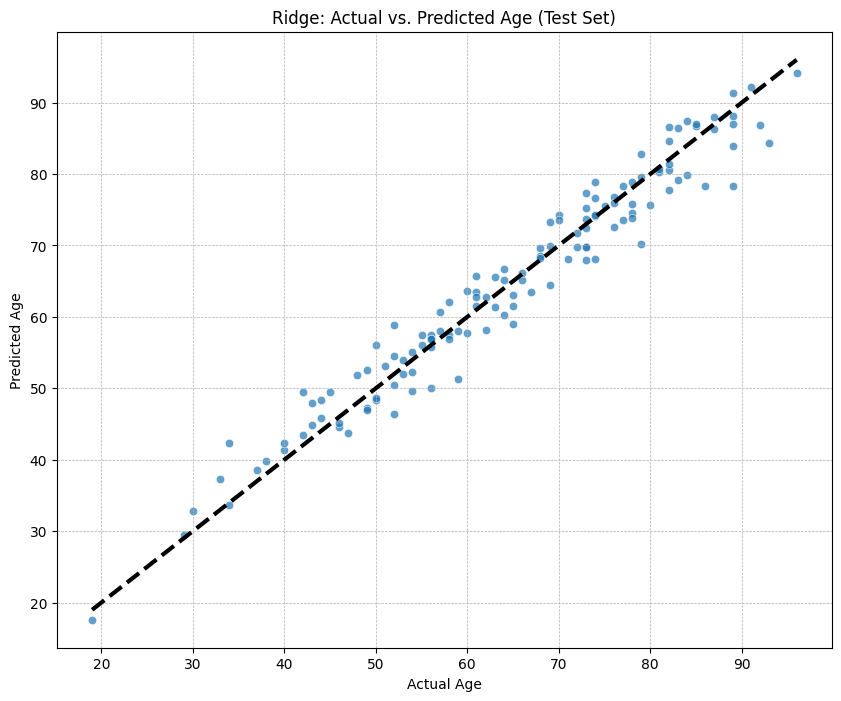

✅ Final Test MSE: 11.9197
✅ Final Test MAE: 2.7359


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title(f'{best_name}: Actual vs. Predicted Age (Test Set)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Calculate metrics
mse_test_final = mean_squared_error(y_test, y_test_pred)
mae_test_final = mean_absolute_error(y_test, y_test_pred)

print(f"✅ Final Test MSE: {mse_test_final:.4f}")
print(f"✅ Final Test MAE: {mae_test_final:.4f}")

## Step 8: Predict & Evaluate on Eval Data

✅ Eval predictions preview:


,Predicted_Age
GSM4753639,55.839803
GSM4753640,58.997316
GSM4753641,47.573113
GSM4753642,54.502194
GSM4753644,49.850240


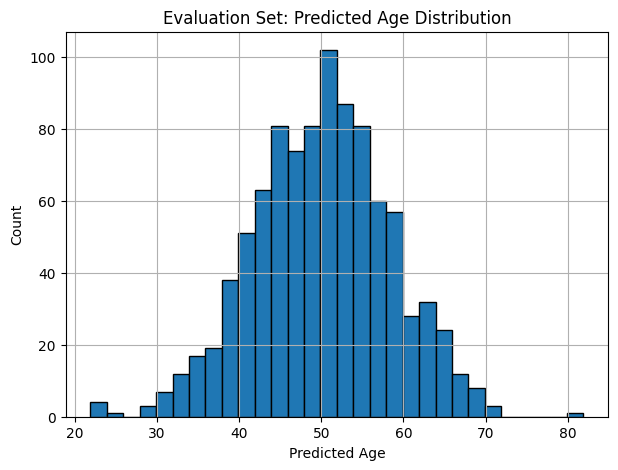

✅ Evaluation predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/GSE157131_predicted_ages.csv


In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Align eval features with training features
X_eval = evaluation_data.dnam.T.copy()

# Ensure all selected CpGs exist in eval data; fill missing with 0
for cpg in set(stable_lasso) - set(X_eval.columns):
    X_eval[cpg] = 0.0

# Reorder columns to match training order
X_eval = X_eval[stable_lasso].values

# Predict using the best model (Ridge)
y_eval_pred = best_mod.predict(X_eval)

# Create DataFrame of predictions
eval_pred_df = pd.DataFrame({
    "Predicted_Age": y_eval_pred
}, index=evaluation_data.dnam.columns)

# Preview predictions
print("✅ Eval predictions preview:")
display(eval_pred_df.head())

# Plot histogram of predicted ages
plt.figure(figsize=(7, 5))
plt.hist(y_eval_pred, bins=30, edgecolor="k")
plt.title("Evaluation Set: Predicted Age Distribution")
plt.xlabel("Predicted Age")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Save predictions to CSV
eval_output_path = os.path.join(output_dir, "GSE157131_predicted_ages.csv")
eval_pred_df.to_csv(eval_output_path)

print(f"✅ Evaluation predictions saved to: {eval_output_path}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


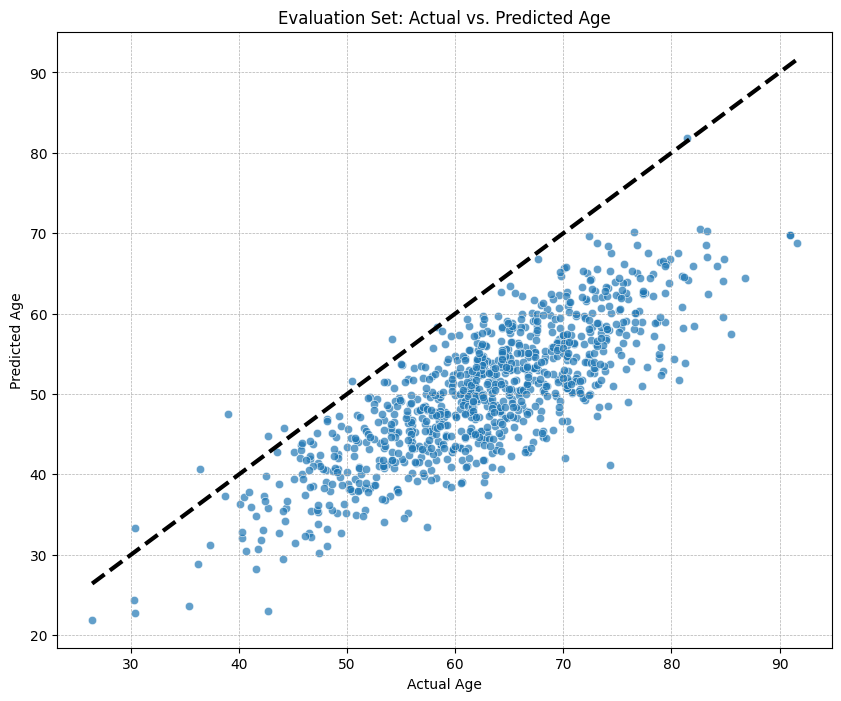

📊 Evaluation MSE: 189.3773
📊 Evaluation MAE: 12.5978
✅ Evaluation predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/EvaluationSet_predictions.csv


In [ ]:
## RidgeCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure consistency of feature columns (add missing CpGs as zeros)
pruned_data = evaluation_data.dnam.T.copy()
missing_cpg_sites = list(set(stable_lasso) - set(pruned_data.columns))
pruned_data.loc[:, missing_cpg_sites] = 0
pruned_data = pruned_data[stable_lasso]

# Predict using best trained model
challenge_results = best_mod.predict(pruned_data)

# Combine predictions with actual ages (if available)
predicted_age_df = pd.DataFrame({
    'predictedAge': challenge_results,
    'ActualAge': evaluation_data.metadata.age
}, index=evaluation_data.dnam.columns)
predicted_age_df.index.name = 'sampleId'

# Plot actual vs predicted
y_pred = challenge_results
y_true = evaluation_data.metadata.age

plt.figure(figsize=(10, 8))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Evaluation Set: Actual vs. Predicted Age')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Metrics
mse_eval = np.mean((y_true - y_pred) ** 2)
mae_eval = np.mean(np.abs(y_true - y_pred))
print(f"📊 Evaluation MSE: {mse_eval:.4f}")
print(f"📊 Evaluation MAE: {mae_eval:.4f}")

# Save predictions
eval_output_path = os.path.join(output_dir, "EvaluationSet_predictions.csv")
predicted_age_df.to_csv(eval_output_path)
print(f"✅ Evaluation predictions saved to: {eval_output_path}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


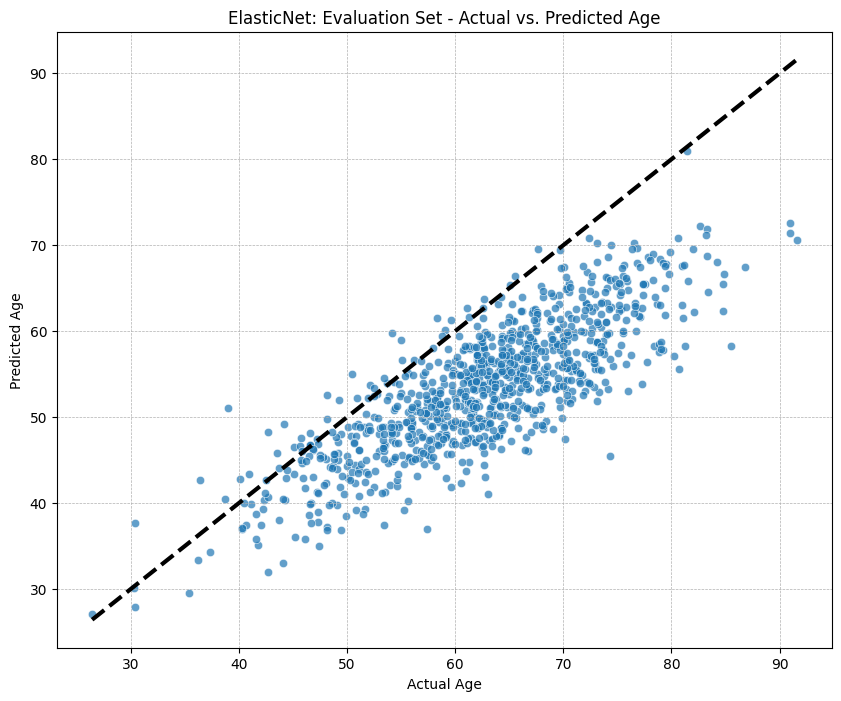

📊 Evaluation MSE (ElasticNet): 114.7665
📊 Evaluation MAE (ElasticNet): 9.3663
✅ Evaluation predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/ElasticNet_EvaluationSet_predictions.csv


In [ ]:
## ElasticNet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Ensure consistency of feature columns (add missing CpGs as zeros)
pruned_data = evaluation_data.dnam.T.copy()
missing_cpg_sites = list(set(stable_lasso) - set(pruned_data.columns))
pruned_data.loc[:, missing_cpg_sites] = 0
pruned_data = pruned_data[stable_lasso]

# Predict using ElasticNet
challenge_results_enet = enet.predict(pruned_data)

# Combine predictions with actual ages
predicted_age_df_enet = pd.DataFrame({
    'predictedAge': challenge_results_enet,
    'ActualAge': evaluation_data.metadata.age
}, index=evaluation_data.dnam.columns)
predicted_age_df_enet.index.name = 'sampleId'

# Plot actual vs predicted
y_pred_enet = challenge_results_enet
y_true_enet = evaluation_data.metadata.age

plt.figure(figsize=(10, 8))
plt.scatter(y_true_enet, y_pred_enet, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([min(y_true_enet), max(y_true_enet)], [min(y_true_enet), max(y_true_enet)], 'k--', lw=3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('ElasticNet: Evaluation Set - Actual vs. Predicted Age')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Metrics
mse_eval_enet = np.mean((y_true_enet - y_pred_enet) ** 2)
mae_eval_enet = np.mean(np.abs(y_true_enet - y_pred_enet))
print(f"📊 Evaluation MSE (ElasticNet): {mse_eval_enet:.4f}")
print(f"📊 Evaluation MAE (ElasticNet): {mae_eval_enet:.4f}")

# Save predictions
eval_output_path_enet = os.path.join(output_dir, "ElasticNet_EvaluationSet_predictions.csv")
predicted_age_df_enet.to_csv(eval_output_path_enet)
print(f"✅ Evaluation predictions saved to: {eval_output_path_enet}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


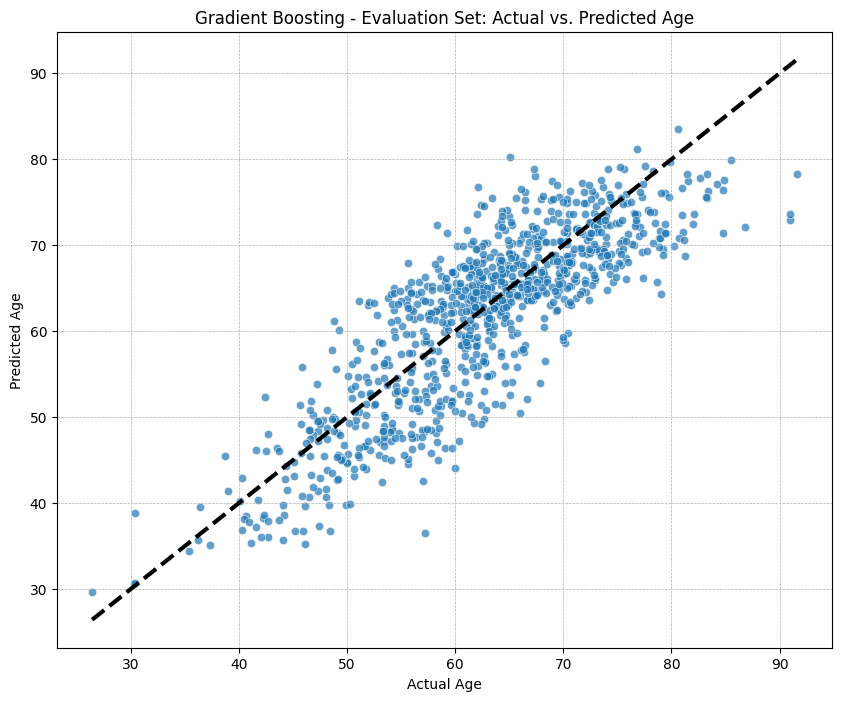

📊 Evaluation MSE (Gradient Boosting): 33.3273
📊 Evaluation MAE (Gradient Boosting): 4.6631


,predictedAge,ActualAge
sampleId,,
GSM4753639,77.483764,68.99
GSM4753640,65.745118,78.69
GSM4753641,54.042336,60.91
GSM4753642,70.414557,69.01
GSM4753644,64.667136,59.96


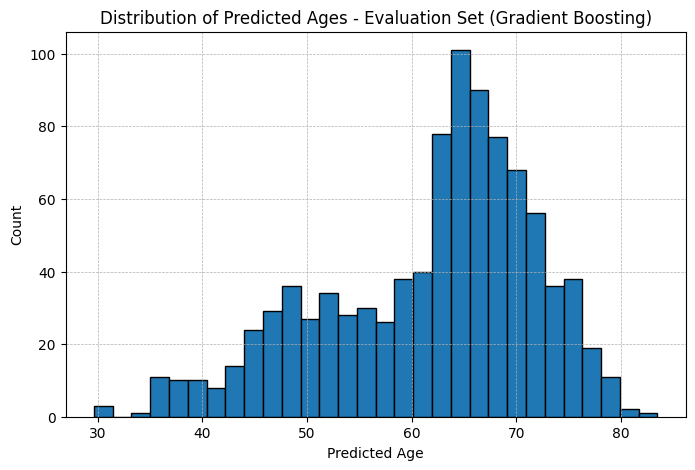

✅ Evaluation predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/EvaluationSet_Predicted_vs_Actual_GB.csv


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step 1: Align evaluation data with training features (fill missing CpGs with 0.0)
pruned_data = evaluation_data.dnam.T.copy()
missing_cpg_sites = list(set(stable_lasso) - set(pruned_data.columns))
pruned_data.loc[:, missing_cpg_sites] = 0
pruned_data = pruned_data[stable_lasso]  # ensure column order

# Step 2: Predict with Gradient Boosting Regressor
y_eval_pred = gb.predict(pruned_data)

# Step 3: Create DataFrame with predictions and actual ages
predicted_age_df = pd.DataFrame({
    'predictedAge': y_eval_pred,
    'ActualAge': evaluation_data.metadata.age
}, index=evaluation_data.dnam.columns)
predicted_age_df.index.name = 'sampleId'

# Step 4: Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(predicted_age_df["ActualAge"], predicted_age_df["predictedAge"], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([min(predicted_age_df["ActualAge"]), max(predicted_age_df["ActualAge"])],
         [min(predicted_age_df["ActualAge"]), max(predicted_age_df["ActualAge"])],
         'k--', lw=3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Gradient Boosting - Evaluation Set: Actual vs. Predicted Age')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Step 5: Compute and print metrics
mse = np.mean((predicted_age_df["ActualAge"] - predicted_age_df["predictedAge"]) ** 2)
mae = np.mean(np.abs(predicted_age_df["ActualAge"] - predicted_age_df["predictedAge"]))
print(f"📊 Evaluation MSE (Gradient Boosting): {mse:.4f}")
print(f"📊 Evaluation MAE (Gradient Boosting): {mae:.4f}")

# Step 6: Show the prediction table
display(predicted_age_df.head())

# Step 7: Plot histogram of predicted ages
plt.figure(figsize=(8, 5))
plt.hist(predicted_age_df["predictedAge"], bins=30, edgecolor='black')
plt.xlabel("Predicted Age")
plt.ylabel("Count")
plt.title("Distribution of Predicted Ages - Evaluation Set (Gradient Boosting)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Step 8: Save results
eval_output_path = os.path.join(output_dir, "EvaluationSet_Predicted_vs_Actual_GB.csv")
predicted_age_df.to_csv(eval_output_path)
print(f"✅ Evaluation predictions saved to: {eval_output_path}")

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

# Initialize base model
gb_base = GradientBoostingRegressor(random_state=42)

# Define MSE scorer (negative because sklearn wants higher=better)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Grid search
grid_search = GridSearchCV(
    gb_base,
    param_grid,
    scoring=mse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model
best_gb = grid_search.best_estimator_
print(f"✅ Best Params: {grid_search.best_params_}")

# Evaluate on test set
y_pred_best_gb = best_gb.predict(X_test)
mse_best_gb = mean_squared_error(y_test, y_pred_best_gb)
print(f"🎯 Tuned Gradient Boosting Test MSE: {mse_best_gb:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


Python(69560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(69567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=3

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


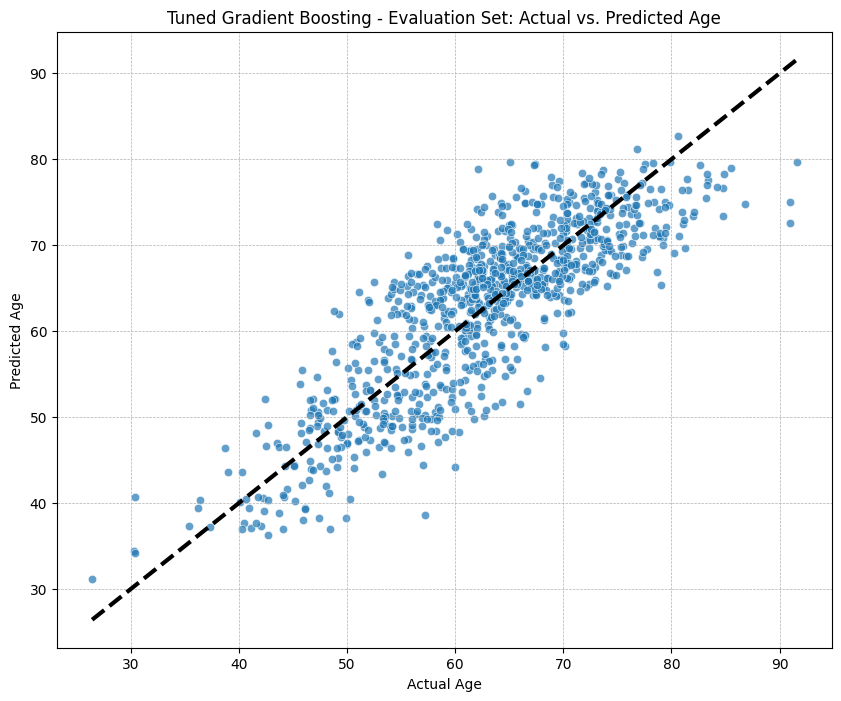

📊 Evaluation MSE (Tuned GB): 31.8569
📊 Evaluation MAE (Tuned GB): 4.5594


,predictedAge,ActualAge
sampleId,,
GSM4753639,76.943688,68.99
GSM4753640,66.823384,78.69
GSM4753641,54.290291,60.91
GSM4753642,71.562896,69.01
GSM4753644,65.604968,59.96


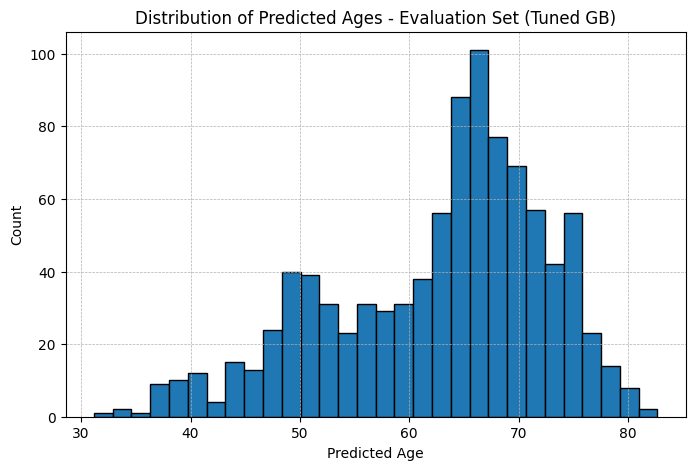

✅ Evaluation predictions saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/EvaluationSet_Predicted_vs_Actual_TunedGB.csv


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step 1: Align evaluation data with training features (fill missing CpGs with 0.0)
pruned_data = evaluation_data.dnam.T.copy()
missing_cpg_sites = list(set(stable_lasso) - set(pruned_data.columns))
pruned_data.loc[:, missing_cpg_sites] = 0
pruned_data = pruned_data[stable_lasso]  # ensure column order

# Step 2: Predict with the tuned Gradient Boosting Regressor
y_eval_pred = best_gb.predict(pruned_data)

# Step 3: Create DataFrame with predictions and actual ages
predicted_age_df = pd.DataFrame({
    'predictedAge': y_eval_pred,
    'ActualAge': evaluation_data.metadata.age
}, index=evaluation_data.dnam.columns)
predicted_age_df.index.name = 'sampleId'

# Step 4: Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(predicted_age_df["ActualAge"], predicted_age_df["predictedAge"], alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([min(predicted_age_df["ActualAge"]), max(predicted_age_df["ActualAge"])],
         [min(predicted_age_df["ActualAge"]), max(predicted_age_df["ActualAge"])],
         'k--', lw=3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Tuned Gradient Boosting - Evaluation Set: Actual vs. Predicted Age')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Step 5: Compute and print metrics
mse = np.mean((predicted_age_df["ActualAge"] - predicted_age_df["predictedAge"]) ** 2)
mae = np.mean(np.abs(predicted_age_df["ActualAge"] - predicted_age_df["predictedAge"]))
print(f"📊 Evaluation MSE (Tuned GB): {mse:.4f}")
print(f"📊 Evaluation MAE (Tuned GB): {mae:.4f}")

# Step 6: Show the prediction table
display(predicted_age_df.head())

# Step 7: Plot histogram of predicted ages
plt.figure(figsize=(8, 5))
plt.hist(predicted_age_df["predictedAge"], bins=30, edgecolor='black')
plt.xlabel("Predicted Age")
plt.ylabel("Count")
plt.title("Distribution of Predicted Ages - Evaluation Set (Tuned GB)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Step 8: Save results
eval_output_path = os.path.join(output_dir, "EvaluationSet_Predicted_vs_Actual_TunedGB.csv")
predicted_age_df.to_csv(eval_output_path)
print(f"✅ Evaluation predictions saved to: {eval_output_path}")

## Step 9: Plot & Save Eval Predictions

📉 Final Evaluation MSE (Tuned GB): 31.8569
📊 Final Evaluation MAE (Tuned GB): 4.5594


,predictedAge,ActualAge
sampleId,,
GSM4753639,76.943688,68.99
GSM4753640,66.823384,78.69
GSM4753641,54.290291,60.91
GSM4753642,71.562896,69.01
GSM4753644,65.604968,59.96
GSM4753645,61.532966,58.92
GSM4753646,64.775163,61.85
GSM4753649,72.493616,70.38
GSM4753650,69.669782,71.57


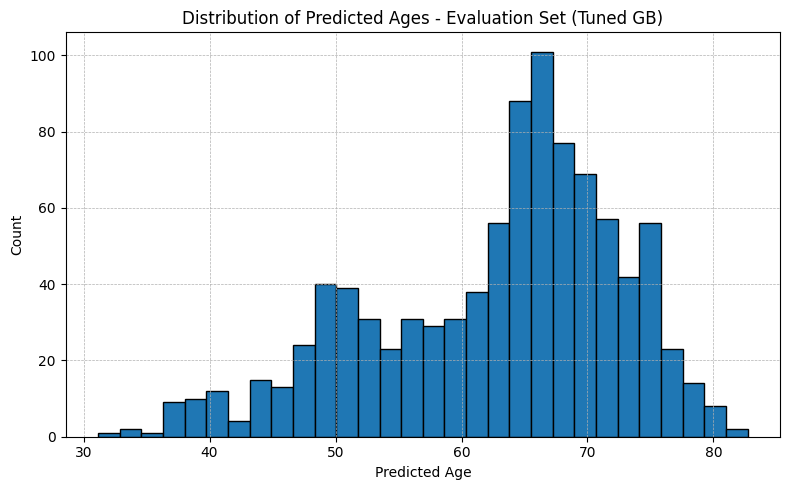

✅ Final prediction table saved to: /Users/lakshmisreyarapolu/Desktop/Project/Capstone Project/New Projects/Project 1/Final_EvaluationSet_Predicted_vs_Actual_TunedGB.csv


In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 🧮 Recompute final metrics
mse_final = np.mean((predicted_age_df["ActualAge"] - predicted_age_df["predictedAge"]) ** 2)
mae_final = np.mean(np.abs(predicted_age_df["ActualAge"] - predicted_age_df["predictedAge"]))

# 📉 Print final evaluation metrics
print(f"📉 Final Evaluation MSE (Tuned GB): {mse_final:.4f}")
print(f"📊 Final Evaluation MAE (Tuned GB): {mae_final:.4f}")

# 📋 Display predicted vs actual table
predicted_age_df.index.name = 'sampleId'
display(predicted_age_df.head(10))  # Top 10 preview

# 📈 Histogram of predicted ages
plt.figure(figsize=(8, 5))
plt.hist(predicted_age_df["predictedAge"], bins=30, edgecolor='black')
plt.xlabel("Predicted Age")
plt.ylabel("Count")
plt.title("Distribution of Predicted Ages - Evaluation Set (Tuned GB)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 💾 Save predictions table to CSV
eval_output_path = os.path.join(output_dir, "Final_EvaluationSet_Predicted_vs_Actual_TunedGB.csv")
predicted_age_df.to_csv(eval_output_path)
print(f"✅ Final prediction table saved to: {eval_output_path}")
